# InceptionV3 : Images - Iteration #4_2: Data Augementation & Fine Tuning

Source image size : 500 x 500 <br>
img_rows = 299  <br>
img_cols = 299 <br>
batch_size =  64 <br>
epochs = 50 <br>
Train set size = 67933 <br>
Valid set size = 16983 <br>
Data augmentation <br>
unfreezing of the last 100 base model layers <br>
optimizer= Adam(learning_rate= 1e-5) <br>
activation function changed from  <font color='red'> sigmoid</font> to  <font color='red'> softmax</font> <br>

**<u>Results</u>**

Accuracy : 0.64 <br>
F1 score weighted : 0.64

**Import packages**

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import re
tqdm_notebook.pandas()
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
import pickle
from joblib import dump, load

# Iteration #4-2 - InceptionV3

***Read DataFrame from saved pickele file - image Train set***

In [2]:
#Load df of images already resized on 256 x 256 
#df_train_im = pd.read_pickle("./saves/df_save/df_train_combined_19102021.pkl")

#Load df of images with org size 500 x 500
df_train_im = pd.read_pickle("./saves/df_save/df_train_combined_ORG_im_size_02122021.pkl")

In [3]:
df_train_im.head()

,designation,description,productid,imageid,prdtypecode,imagePath
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,image_1263597046_product_3804725264.jpg
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,image_1008141237_product_436067568.jpg
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,image_938777978_product_201115110.jpg
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280,image_457047496_product_50418756.jpg
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,image_1077757786_product_278535884.jpg


In [4]:
display(df_train_im.shape)

(84916, 6)

***Create Dataframe containing  product classes and their associated labels***

In [5]:
#Dictionary of prdtypecode and their corresponding categories
dict_prdtypecode = {"prdtypecode" : [50, 2705, 2522, 2582, 1560, 1281, 1920, 1280, 1140, 1300, 2060, 2583,
                                     60, 1320, 2280, 1302, 2220, 40, 2905, 2585, 1940, 1160, 1301, 10, 1180,
                                     2403, 2462],                 
            
                    "Label" : ["video games accessories", "books", "stationery", "kitchen and garden", 
                               "interior furniture and bedding", "board games", "interior accessories",
                               "toys for children","goodies", "remote controlled models", "decoration interior",
                               "piscine spa","games and consoles", "early childhood", "magazines", "kids toys",
                               "supplies for domestic animals", "imported video games", "online distribution of video games",
                               "gardening and DIY","Food","playing cards", "accessories children", "adult books",
                               "figurines_wargames", "children books",
                                "games"]
                   }
df_class = pd.DataFrame(data=dict_prdtypecode)
df_class

,prdtypecode,Label
0,50,video games accessories
1,2705,books
2,2522,stationery
3,2582,kitchen and garden
4,1560,interior furniture and bedding
5,1281,board games
6,1920,interior accessories
7,1280,toys for children
8,1140,goodies
9,1300,remote controlled models


In [6]:
# Crate DF containing prdtypecode , categories and corresponding class used by model
df_class = df_class.sort_values(by = 'prdtypecode', ascending = True)
df_class['target_prdtypecode'] = [i for i in range(27)]
df_class

,prdtypecode,Label,target_prdtypecode
23,10,adult books,0
17,40,imported video games,1
0,50,video games accessories,2
12,60,games and consoles,3
8,1140,goodies,4
21,1160,playing cards,5
24,1180,figurines_wargames,6
7,1280,toys for children,7
5,1281,board games,8
9,1300,remote controlled models,9


***Change the 27 product codes to 0 to 26***

In [7]:
df_train_im.replace({'prdtypecode':{10:0,
                                    40:1,
                                    50:2,
                                    60:3,
                                    1140:4,
                                    1160:5,
                                    1180:6,
                                    1280:7,
                                    1281:8,
                                    1300:9                                    
                                    }}, inplace = True)

df_train_im.replace({'prdtypecode':{1301:10,
                                    1302:11,
                                    1320:12,
                                    1560:13,
                                    1920:14,
                                    1940:15,
                                    2060:16,
                                    2220:17,
                                    2280:18,
                                    2403:19,
                                    2462:20,
                                    2522:21,
                                    2582:22,
                                    2583:23,
                                    2585:24,
                                    2705:25,
                                    2905:26
                                    }}, inplace = True)

In [8]:
display(df_train_im["prdtypecode"].unique())

array([ 0, 18,  2,  7, 25, 21, 22, 13,  8, 14, 19,  4, 23,  6,  9, 20,  5,
       16,  1,  3, 12, 11, 17, 26, 24, 15, 10], dtype=int64)

 ***Convert product code to string type***

In [9]:
df_train_im["prdtypecode"] = df_train_im["prdtypecode"].astype(str)

In [10]:
unique, counts = np.unique(df_train_im["prdtypecode"], return_counts=True)
dict(zip(unique, counts))

{'0': 3116,
 '1': 2508,
 '10': 807,
 '11': 2491,
 '12': 3241,
 '13': 5073,
 '14': 4303,
 '15': 803,
 '16': 4993,
 '17': 824,
 '18': 4760,
 '19': 4774,
 '2': 1681,
 '20': 1421,
 '21': 4989,
 '22': 2589,
 '23': 10209,
 '24': 2496,
 '25': 2761,
 '26': 872,
 '3': 832,
 '4': 2671,
 '5': 3953,
 '6': 764,
 '7': 4870,
 '8': 2070,
 '9': 5045}

 ***Split Train Set***

In [11]:
# Split Train set 
X_train_im, X_test_im = train_test_split(df_train_im, train_size=0.8, random_state=1234)

In [12]:
display(X_train_im.shape)
display(X_test_im.shape)

(67932, 6)

(16984, 6)

***Data Generator***

In [13]:
img_rows = 299
img_cols = 299
batch_size = 64
epochs = 50

# Directory of images already resized on 256 x 256 
#images_dir_train = './data/images/all/image_train_resized/'
#images_dir_train = 'E:/WorkSpace_DataScience_E/Rakuten_Projet_Local/My_WS/data/images/all/image_train_resized/'

# Directory of images org resize 500 x 500
images_dir_train = './data/images/all/image_train/'
#images_dir_train = 'E:/WorkSpace_DataScience_E/Rakuten_Projet_Local/My_WS/data/images/all/image_train/'

In [14]:
%%time
#Générateur de données
train_datagen = ImageDataGenerator(rescale = 1/255,
                                  shear_range=0.2,
                                  rotation_range = 45,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True
                                  #validation_split = 0.2
                                )

Wall time: 0 ns


In [15]:
%%time
valid_datagen = ImageDataGenerator(rescale=1./255)

Wall time: 0 ns


In [16]:
%%time

#Itérateur 
train_generator = train_datagen.flow_from_dataframe(dataframe = X_train_im,
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                             
                                              target_size = (img_rows , img_cols), # default 256 x 256                                             
                                              batch_size = batch_size,                                             
                                              shuffle = True  # défault
                                              #subset = 'training'
                                             )

Found 67932 validated image filenames belonging to 27 classes.
Wall time: 6.97 s


In [17]:
%%time
# validation_split the validation batches ca be retrieved by specifying the subset as validation.
valid_generator = valid_datagen.flow_from_dataframe(dataframe = X_test_im, 
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                        
                                              target_size = (img_rows , img_cols), # default 256 x 256                                         
                                              batch_size = batch_size, 
                                              shuffle = False
                                              #subset  = 'validation'
                                             )

Found 16984 validated image filenames belonging to 27 classes.
Wall time: 1.3 s


 ***InceptionV3 Implementation  - with fine tuning***

In [18]:
%%time
# Chargement du modèle InceptionV3
inceptionV3  = InceptionV3(weights='imagenet', include_top = False, input_shape=(img_rows,img_rows,3))

# Bloquage du blackbone
for layer in inceptionV3.layers:
    layer.trainable = False   

Wall time: 3.97 s


***Unfreeze the last 100 layers of the base_model***

In [19]:
for layer in inceptionV3.layers[-100:]:
    layer.trainable = True

In [20]:
model = Sequential()
model.add(inceptionV3)
# Ajout des couche de classification as VGG16 efficientNet , ResNet different!
model.add(GlobalAveragePooling2D()) 
model.add(Dense(units = 1024,activation='relu'))

model.add(Dropout(rate = 0.2))
model.add(Dense(units = 512, activation='relu'))

model.add(Dropout(rate = 0.2))
model.add(Dense(units = 27, activation='softmax'))
#model.add(Dense(units = 27, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)                1

In [21]:
#print(len(denseNet121.layers))
#print(len(model.layers))
print('Last the last ten layers base model - inceptionV3: \n ')  
for layer in inceptionV3.layers[-10:]:
    print("                 ", layer.name, "  " , layer.trainable)
    
print('\n Layers of built model: \n')  

for layer in model.layers:
    print("                 ", layer.name, "  " , layer.trainable)

Last the last ten layers base model - inceptionV3: 
 
                  activation_87    True
                  activation_88    True
                  activation_91    True
                  activation_92    True
                  batch_normalization_93    True
                  activation_85    True
                  mixed9_1    True
                  concatenate_1    True
                  activation_93    True
                  mixed10    True

 Layers of built model: 

                  inception_v3    True
                  global_average_pooling2d    True
                  dense    True
                  dropout    True
                  dense_1    True
                  dropout_1    True
                  dense_2    True


 ***Compilation***

In [22]:
%%time
# Compilation
model.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer= Adam(learning_rate= 1e-5) ,   #default lr = 0.001 # algorithme de descente de gradient
              metrics=['accuracy'])                    # métrique d'évaluation

Wall time: 8.98 ms


***Callbacks***

In [23]:
%%time
path = './saves/InceptionV3/Iteration_4_2/'
file_name = 'checkpoint_InceptionV3_13122021_Shape-299x299_50Epochs.h5'

checkpoint = ModelCheckpoint(filepath = path + file_name , 
                             monitor ='val_accuracy',
                             verbose = 1,
                             save_best_only = True, # (pour que le meilleur modèle ne soit pas écrasé)
                             save_weights_only = False,
                             mode ='max', #(permet de préciser si la métrique doit croître ou décroitre : ici on choisit 'min'
                                           #car la métrique est une perte à minimiser)
                             save_freq='epoch')
#Arrêter l'entraînement si le modèle n'évolue plus (très pratique pour ne pas gérer le
#nombre d'epoch) :
early = EarlyStopping(monitor='val_loss',
                      min_delta = 0,
                      patience = 10, #(nombre d'epochs à attendre avant d'arrêter l'entraînement
                      restore_best_weights = True,
                      verbose = 1,
                      mode = 'min')

lr_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                              patience = 10,
                              verbose = 1,
                              mode='min'
                              )

Wall time: 0 ns


 ***Fit - train_generator***

In [24]:
step_size_Train = train_generator.n//train_generator.batch_size
step_size_Valid = valid_generator.n//valid_generator.batch_size
print('step_size_Train : ' , step_size_Train)
print('step_size_Valid  : ' , step_size_Valid)

step_size_Train :  1061
step_size_Valid  :  265


In [25]:
%%time
# Fit Train generator
history = model.fit(train_generator,                    
                    epochs = epochs,                   
                    steps_per_epoch = step_size_Train,
                    validation_data = valid_generator,
                    validation_steps = step_size_Valid,
                    callbacks=[checkpoint, early, lr_plateau]
                    
                    )

Epoch 1/50
1061/1061 [==============================] - 1290s 1s/step - loss: 2.2303 - accuracy: 0.3714 - val_loss: 1.6938 - val_accuracy: 0.5026

Epoch 00001: val_accuracy improved from -inf to 0.50259, saving model to ./saves/InceptionV3/Iteration_4_2\checkpoint_InceptionV3_13122021_Shape-299x299_50Epochs.h5
Epoch 2/50
1061/1061 [==============================] - 1193s 1s/step - loss: 1.6913 - accuracy: 0.5033 - val_loss: 1.4996 - val_accuracy: 0.5564

Epoch 00002: val_accuracy improved from 0.50259 to 0.55637, saving model to ./saves/InceptionV3/Iteration_4_2\checkpoint_InceptionV3_13122021_Shape-299x299_50Epochs.h5
Epoch 3/50
1061/1061 [==============================] - 1173s 1s/step - loss: 1.5329 - accuracy: 0.5454 - val_loss: 1.4107 - val_accuracy: 0.5781

Epoch 00003: val_accuracy improved from 0.55637 to 0.57812, saving model to ./saves/InceptionV3/Iteration_4_2\checkpoint_InceptionV3_13122021_Shape-299x299_50Epochs.h5
Epoch 4/50
1061/1061 [==============================] - 11

***Save History results***

In [26]:
# Save History results
path = './saves/InceptionV3/Iteration_4_2/'
filename = 'history_InceptionV3_all_train_13122021_Shape-299x299_50Epochs'

In [27]:
#convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# history to json:  
hist_json_file = path + filename + '.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# history to csv: 
hist_csv_file = path + filename +'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# history to pickle file
hist_df.to_pickle(path + filename +'.pkl')

***Display Model loss , accuracy per epoch***

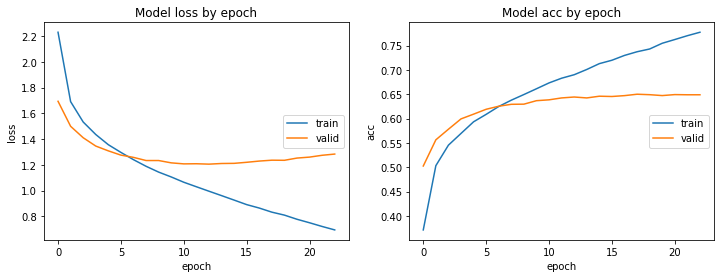

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

 ***Prediction - test_generator***

In [29]:
%%time
#Prediction - Valid set
y_pred_proba = model.predict(valid_generator)

# l'argmax pour obtenir les classes prédites
y_pred_class = np.argmax(y_pred_proba,axis = 1).astype(int)

# To get classes from test generator
y_true = valid_generator.classes

Wall time: 1min 4s


 ***Evaluation - test_generator***

In [30]:
%%time
#Get the accuracy score
valid_score = model.evaluate(valid_generator)
print("[INFO] Model metrics names:", model.metrics_names)
print("[INFO] Accuracy: {:.2f}%".format(valid_score[1] * 100)) 
print("[INFO] Loss: ",valid_score[0])

266/266 [==============================] - 62s 231ms/step - loss: 1.2054 - accuracy: 0.6443
[INFO] Model metrics names: ['loss', 'accuracy']
[INFO] Accuracy: 64.43%
[INFO] Loss:  1.2054411172866821
Wall time: 1min 2s


In [31]:
f1_macro = f1_score(y_true, y_pred_class, average='macro')
print("[INFO] f1 score macro average: ",f1_macro)

f1_micro = f1_score(y_true, y_pred_class, average='micro')
print("[INFO] f1 score micro average: ",f1_micro)

f1_weighted = f1_score(y_true, y_pred_class, average='weighted')
print("[INFO] f1 score weighted average: ",f1_weighted)

[INFO] f1 score macro average:  0.592293100019829
[INFO] f1 score micro average:  0.6442534149788036
[INFO] f1 score weighted average:  0.6368398132626002


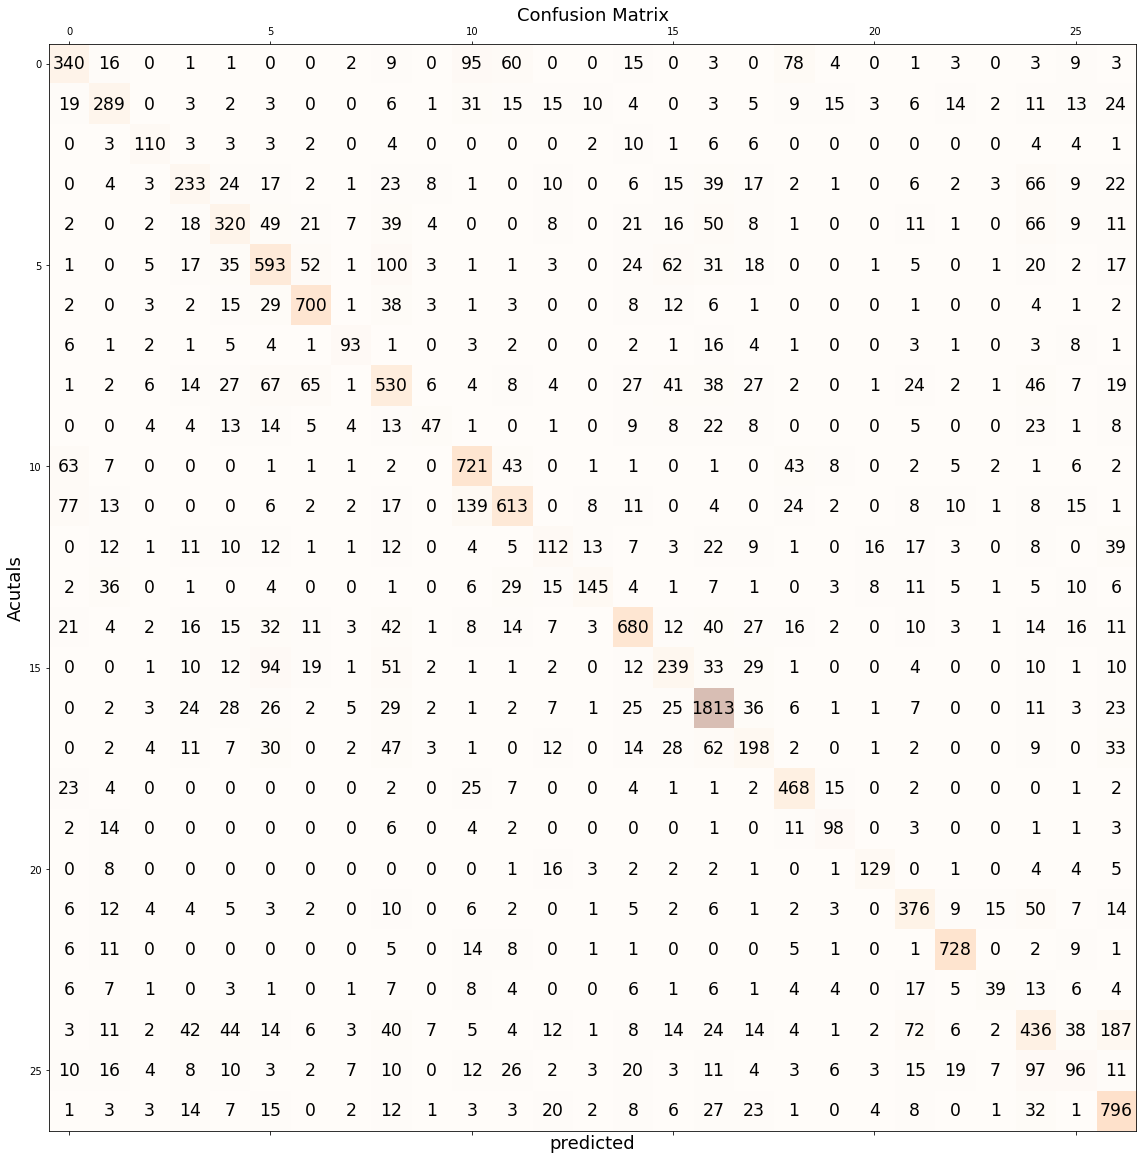

In [32]:
#Confusion matrix
matrix = confusion_matrix(y_true, y_pred_class)
fig , ax = plt.subplots(figsize = (24,20))
ax.matshow(matrix, cmap = plt.cm.Oranges , alpha = 0.3)
for i in range(matrix.shape[0]):
    for j in range (matrix.shape[1]):
        ax.text (x = j , y= i, s= matrix[i,j], va = 'center', ha = 'center', size = 'xx-large')
        
plt.xlabel('predicted', fontsize = 18)
plt.ylabel('Acutals', fontsize = 18)
plt.title('Confusion Matrix', fontsize = 18)
plt.show()
#print(matrix)

In [33]:
print(metrics.classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.58      0.53      0.55       643
           1       0.61      0.57      0.59       503
           2       0.69      0.68      0.68       162
           3       0.53      0.45      0.49       514
           4       0.55      0.48      0.51       664
           5       0.58      0.60      0.59       993
           6       0.78      0.84      0.81       832
           7       0.67      0.58      0.63       159
           8       0.50      0.55      0.52       970
           9       0.53      0.25      0.34       190
          10       0.66      0.79      0.72       911
          11       0.72      0.64      0.68       961
          12       0.46      0.35      0.40       319
          13       0.75      0.48      0.59       301
          14       0.73      0.67      0.70      1011
          15       0.48      0.45      0.47       533
          16       0.80      0.87      0.83      2083
          17       0.45    

 ***Predict input image using trained model***

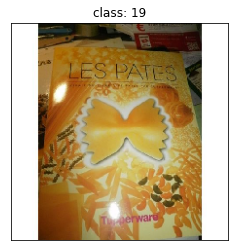

In [34]:
# Predict With Pre Trained

# Load an image
im_id = 255
#img_path ='./data/images/all/image_train_resized/'+ df_train_im['imagePath'][im_id]
img_path ='./data/images/all/image_train/'+ df_train_im['imagePath'][im_id]

img = image.load_img(img_path,target_size=(224, 224))
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.title("class: " + str(df_train_im['prdtypecode'][im_id]))
plt.xticks([])
plt.yticks([])
#plt.axis('off')
plt.show();

In [35]:
im = cv2.resize(cv2.imread(img_path), (299, 299))
im = np.expand_dims(im, axis=0)

In [36]:
out = model.predict(im)
print("------------------Predicted Class and Label ------------------------------")
print("target class(used by model) :", np.argmax(out))
print("\n"  ,df_class[df_class['target_prdtypecode'] == np.argmax(out)][['prdtypecode', 'Label']].to_string(index=False)) 

prd_code = df_train_im['prdtypecode'][im_id]

print("\n\n------------------Real Class and Label ------------------------------")
print("target class(used by model): " ,  df_class[df_class['target_prdtypecode'] == int(prd_code)]['target_prdtypecode'].to_string(index=False))
print("\n"  ,df_class[df_class['target_prdtypecode'] == int(prd_code)][['prdtypecode', 'Label']].to_string(index=False)) 


 


------------------Predicted Class and Label ------------------------------
target class(used by model) : 8

  prdtypecode       Label
        1281 board games


------------------Real Class and Label ------------------------------
target class(used by model):  19

  prdtypecode          Label
        2403 children books


 ***Save InceptionV3 Model***

In [37]:
#Enregistrement du modèle
model.save("./saves/InceptionV3/Iteration_4_2/Model_InceptionV3_All_train_data_13122021_Shape-299x299_50Epochs.hdf5")
#The SavedModel and HDF5 file contains:
#the model's configuration (topology)
#the model's weights
#the model's optimizer's state (if any)

 ***Load DenseNet121 Model***

In [ ]:
#Rechargement du modèle :
model = load_model("./saves/InceptionV3/Iteration_4_2/Model_InceptionV3_All_train_data_13122021_Shape-299x299_50Epochs.hdf5")